In [2]:
#importing required packages 
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
from dateutil import parser

# Data visualization packages
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import seaborn as sns

In [3]:
api_key = ""

In [38]:
#channel IDs is a list where we can pass multiple channel ids separated by ,. for now we are only considering one channel - Guyskills which is tamil regional entertainment channel.

channel_ids = ['UCH_hJVlFlFWQV2zQsjkQo5Q',
               #more channels here
              ]

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)


In [6]:
#this function is used for retrieval of channel stats such as channel name, sub count, views, total videos and playlist id . This provides high level info on the channel.
def get_channel_stats(youtube, channel_ids):
    all_data =[]
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()
    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos':item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        all_data.append(data)
    return(pd.DataFrame(all_data))

In [7]:
channel_stats = get_channel_stats(youtube,channel_ids)

In [8]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Guy Skills,79800,3736992,304,UUH_hJVlFlFWQV2zQsjkQo5Q


In [40]:
#this function is to provide video id's on the channels, All the video id's on the channel is retrived using the playlist id. 
#If multiple channels are considered then playlist Id has to be derived from above df and looped to get all video id on each channel. finally append the data.
#returned object is a list of video id's.
playlist_id = "UUH_hJVlFlFWQV2zQsjkQo5Q"
def get_video_Ids(youtube,playlist_id):
    video_ids = []
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        maxResults=50,
        playlistId=playlist_id,
    )
    response = request.execute()
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    next_page_token= response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        maxResults=50,
        playlistId=playlist_id,
        pageToken = next_page_token)
        response = request.execute()
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        next_page_token= response.get('nextPageToken')
    return video_ids


In [10]:
video_ids = get_video_Ids(youtube,playlist_id)

In [11]:
len(video_ids)

305

In [12]:
# get video details
def get_video_details(youtube,video_ids):
    all_video_info =[]
    for i in range(0, len(video_ids),50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()
    
        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle','title','description','publishedAt','tags'],
                             'statistics':['viewCount','likeCount','favoriteCount','commentCount'],
                             'contentDetails':['duration','definition','caption','licensedContent']
                            }
            video_info ={}
            video_info['video_id']=video['id']
            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v]=video[k][v]
                    except:
                        video_info[v]=None
            all_video_info.append(video_info)
    return pd.DataFrame(all_video_info)

In [13]:
video_df = get_video_details(youtube,video_ids)

In [14]:
video_df.head()

,video_id,channelTitle,title,description,publishedAt,tags,viewCount,likeCount,favoriteCount,commentCount,duration,definition,caption,licensedContent
0,veg9tl7Vtss,Guy Skills,தமிழா தமிழா Men 🗿 | Thursday Tharkuris | Guysk...,Insta SENCES: https://www.instagram.com/sences...,2024-12-12T15:15:06Z,"[thursday tharkuris, reels reactions, guyskill...",57723,5101,0,263,PT14M33S,hd,false,True
1,7UwD70Ec_3E,Guy Skills,ANNOUNCEMENT Part - 1 🫡,Why waste time on description when you can wat...,2024-12-05T15:22:21Z,None,6768,588,0,26,PT19M56S,hd,false,False
2,yL4DW03o6zI,Guy Skills,மூடநம்பிக்கை Reels Reaction | Thursday Tharkur...,Why waste time on description when you can wat...,2024-11-28T15:30:06Z,"[guyskills, thursday tharkuris, thursday thark...",52084,4276,0,280,PT16M52S,hd,false,True
3,4q2kZNO2KL8,Guy Skills,Feminism Troll Reaction | Guyskills | Thursday...,Why waste time on description when you can wat...,2024-11-21T15:30:06Z,"[feminism, feminism tamil, guyskills, thursday...",52559,4499,0,262,PT13M26S,hd,false,True
4,n7gPKsWrOTs,Guy Skills,Nenjumudi Paasapinaipu Ep - 4 | Funniest QnA |...,Why waste time on description when you can wat...,2024-11-17T12:00:06Z,"[guyskills, nenjumudi paasapinaipu, thursday t...",24619,2330,0,113,PT11M53S,hd,false,True


# Data Pre-Processing

In [15]:
# null count 
video_df.isnull().sum()

video_id            0
channelTitle        0
title               0
description         0
publishedAt         0
tags               34
viewCount           0
likeCount          19
favoriteCount       0
commentCount        1
duration            0
definition          0
caption             0
licensedContent     0
dtype: int64

In [16]:
video_df.dtypes

video_id           object
channelTitle       object
title              object
description        object
publishedAt        object
tags               object
viewCount          object
likeCount          object
favoriteCount      object
commentCount       object
duration           object
definition         object
caption            object
licensedContent      bool
dtype: object

In [17]:
numerical_Col = ['viewCount','likeCount','favoriteCount','commentCount']
video_df[numerical_Col] = video_df[numerical_Col].apply(pd.to_numeric,errors='coerce', axis = 1)

In [18]:
# published day in the week
video_df['publishedAt']= video_df['publishedAt'].apply(lambda X: parser.parse(X))
video_df['publishedDayName']= video_df['publishedAt'].apply(lambda X:X.strftime('%A'))

In [19]:
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [20]:
video_df[['durationSecs','duration']].head()

,durationSecs,duration
0,0 days 00:14:33,PT14M33S
1,0 days 00:19:56,PT19M56S
2,0 days 00:16:52,PT16M52S
3,0 days 00:13:26,PT13M26S
4,0 days 00:11:53,PT11M53S


In [21]:
video_df['durationSecs'] = video_df['durationSecs'].astype('int64')

In [22]:
video_df[['durationSecs','duration']].head()

,durationSecs,duration
0,873,PT14M33S
1,1196,PT19M56S
2,1012,PT16M52S
3,806,PT13M26S
4,713,PT11M53S


In [23]:
# Add Tag count column

video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [24]:
video_df.head()

,video_id,channelTitle,title,description,publishedAt,tags,viewCount,likeCount,favoriteCount,commentCount,duration,definition,caption,licensedContent,publishedDayName,durationSecs,tagCount
0,veg9tl7Vtss,Guy Skills,தமிழா தமிழா Men 🗿 | Thursday Tharkuris | Guysk...,Insta SENCES: https://www.instagram.com/sences...,2024-12-12 15:15:06+00:00,"[thursday tharkuris, reels reactions, guyskill...",57723.0,5101.0,0.0,263.0,PT14M33S,hd,false,True,Thursday,873,7
1,7UwD70Ec_3E,Guy Skills,ANNOUNCEMENT Part - 1 🫡,Why waste time on description when you can wat...,2024-12-05 15:22:21+00:00,None,6768.0,588.0,0.0,26.0,PT19M56S,hd,false,False,Thursday,1196,0
2,yL4DW03o6zI,Guy Skills,மூடநம்பிக்கை Reels Reaction | Thursday Tharkur...,Why waste time on description when you can wat...,2024-11-28 15:30:06+00:00,"[guyskills, thursday tharkuris, thursday thark...",52084.0,4276.0,0.0,280.0,PT16M52S,hd,false,True,Thursday,1012,11
3,4q2kZNO2KL8,Guy Skills,Feminism Troll Reaction | Guyskills | Thursday...,Why waste time on description when you can wat...,2024-11-21 15:30:06+00:00,"[feminism, feminism tamil, guyskills, thursday...",52559.0,4499.0,0.0,262.0,PT13M26S,hd,false,True,Thursday,806,11
4,n7gPKsWrOTs,Guy Skills,Nenjumudi Paasapinaipu Ep - 4 | Funniest QnA |...,Why waste time on description when you can wat...,2024-11-17 12:00:06+00:00,"[guyskills, nenjumudi paasapinaipu, thursday t...",24619.0,2330.0,0.0,113.0,PT11M53S,hd,false,True,Sunday,713,7


In [25]:
video_df.to_csv('youtube-Data.csv')

# EDA

Best performing videos

C:\Users\Welcome\AppData\Local\Temp\ipykernel_23352\220866667.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


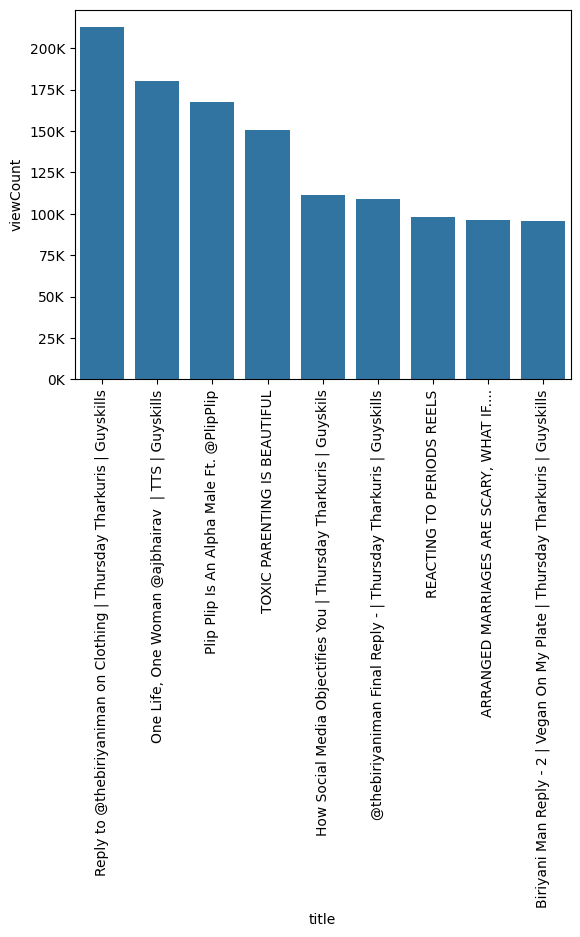

In [26]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))


Worst Perfoming Videos

C:\Users\Welcome\AppData\Local\Temp\ipykernel_23352\171811544.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


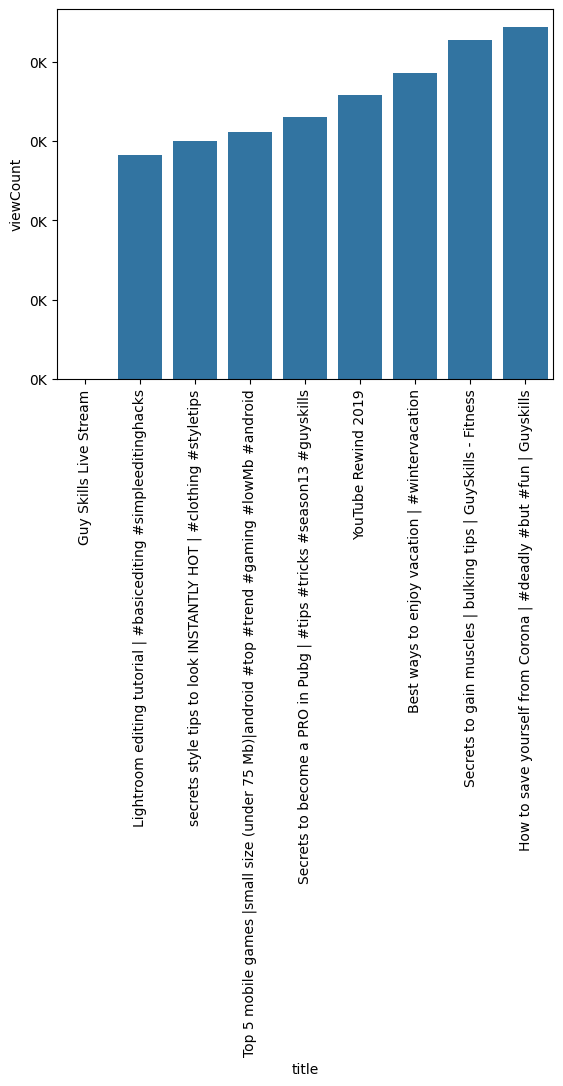

In [27]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

View distribution per video

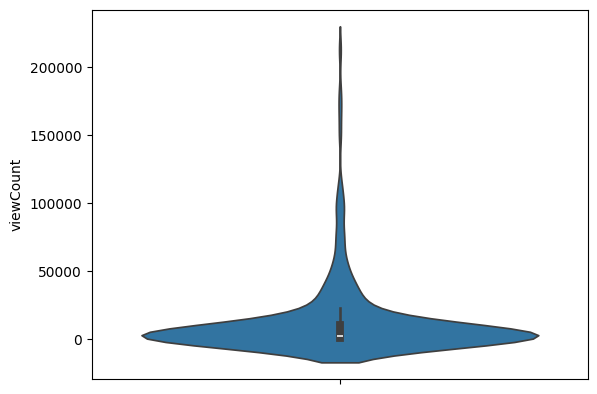

In [28]:
ax= sns.violinplot(video_df['viewCount'])


<Axes: xlabel='likeCount', ylabel='viewCount'>

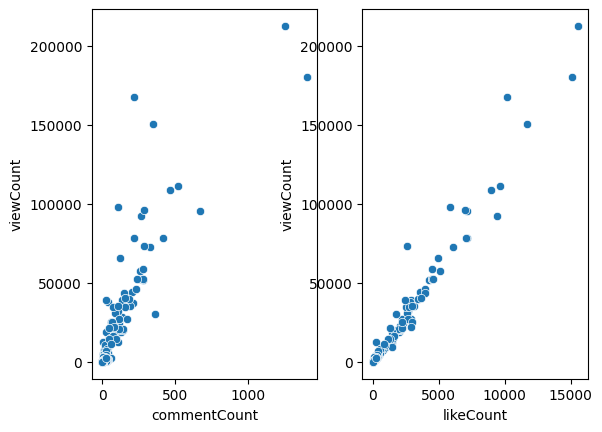

In [29]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

<Axes: xlabel='durationSecs', ylabel='Count'>

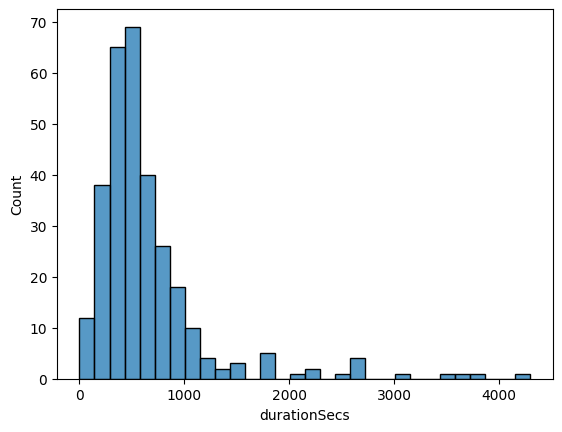

In [30]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

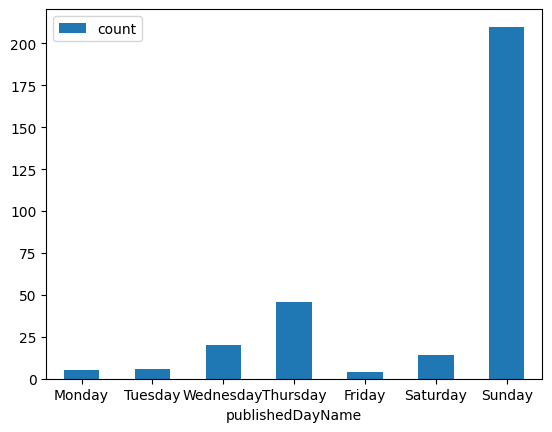

In [36]:
day_df = pd.DataFrame(video_df['publishedDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.plot.bar(y='count', rot=0)